## Using Efficient Deep Learning to Classifying Disease Severity of COVID-19 Patients by using Saudi  X-ray Chest Images 

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
!pip install --user torchvision

In [8]:
%matplotlib inline
import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.6.0


# Preparing Training and Test Sets

In [9]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID_19_Radiography_Database'
source_dirs = ['NORMAL', 'Viral_Pneumonia', 'COVID_19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [10]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [11]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [12]:
train_dirs = {
    'normal': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/train/normal',
    'viral': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/train/viral',
    'covid': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/train/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 590 covid examples


In [13]:
test_dirs = {
    'normal': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/test/normal',
    'viral': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/test/viral',
    'covid': '/ibex/scratch/alsaedsb/COVID_19/DATASETS/COVID_19_Radiography_Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [14]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 536
Number of test batches 15


# Data Visualization

In [15]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

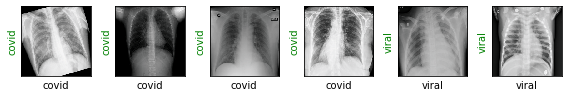

In [16]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

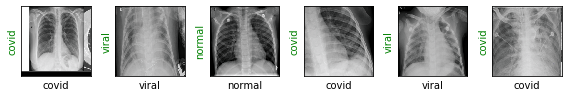

In [17]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [18]:
resnet18 = torchvision.models.resnet18(pretrained=False)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [20]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

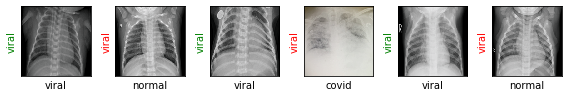

In [21]:
show_preds()

# Training the Model

In [22]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.1704, Accuracy: 0.3333


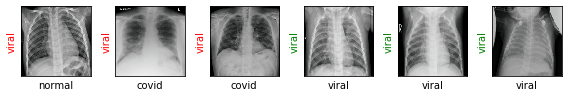

Evaluating at step 20
Validation Loss: 1.2718, Accuracy: 0.3667


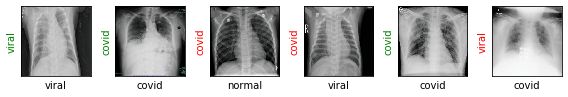

Evaluating at step 40
Validation Loss: 0.9794, Accuracy: 0.6333


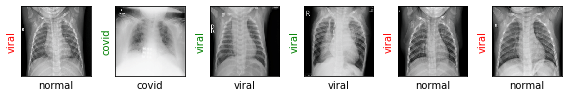

Evaluating at step 60
Validation Loss: 0.6626, Accuracy: 0.6889


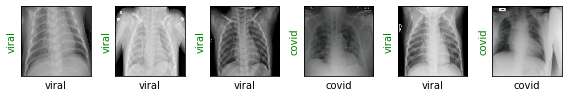

Evaluating at step 80
Validation Loss: 0.6067, Accuracy: 0.7667


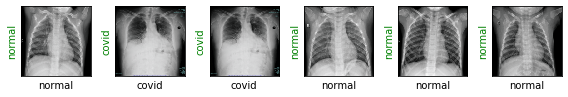

Evaluating at step 100
Validation Loss: 0.5214, Accuracy: 0.8000


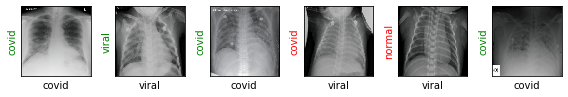

Evaluating at step 120
Validation Loss: 0.5759, Accuracy: 0.8222


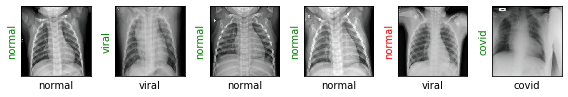

Evaluating at step 140
Validation Loss: 0.4869, Accuracy: 0.8000


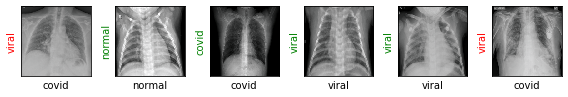

Evaluating at step 160
Validation Loss: 0.6680, Accuracy: 0.7111


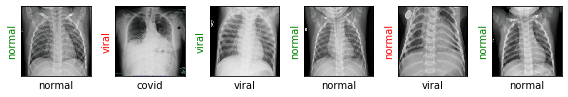

Evaluating at step 180
Validation Loss: 0.6036, Accuracy: 0.7444


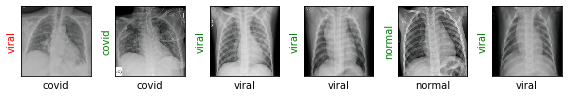

Evaluating at step 200
Validation Loss: 0.3123, Accuracy: 0.9222


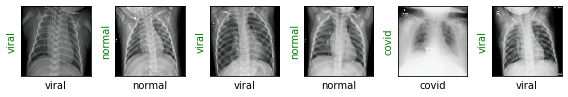

Evaluating at step 220
Validation Loss: 0.5895, Accuracy: 0.7222


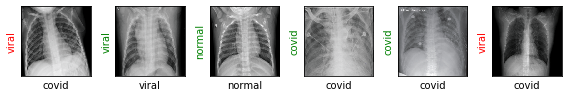

Evaluating at step 240
Validation Loss: 0.5166, Accuracy: 0.8000


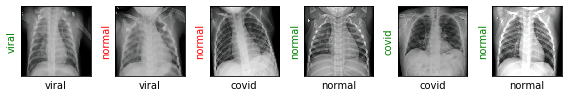

KeyboardInterrupt: 

In [23]:
%%time

train(epochs=1)

# Final Results

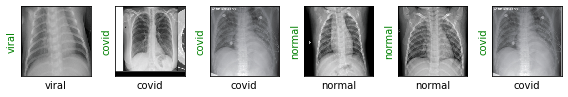

In [24]:
show_preds()

# Result Analysis 

In [31]:
samples = 100
device = torch.device("cuda:0" if (torch.cuda.is_available() and 1 > 0) else "cpu")
def find_scores(model, num_images=samples):
    was_training = model.training
    model.eval()
    images_so_far = 0
    correct_preds = 0
    wrong_preds = 0
    TP_0 = 0
    TP_1 = 0
    TP_2 = 0
    TN_0 = 0
    TN_1 = 0
    TN_2 = 0
    FP_0 = 0
    FP_1 = 0
    FP_2 = 0
    FN_0 = 0
    FN_1 = 0
    FN_2 = 0
    TP = 0.00001
    FP = 0.000001
    TN = 0.0000001
    FN = 0.00000001
    con01 = 0
    con02 = 0
    con10 = 0
    con12 = 0
    con20 = 0
    con21 = 0
    precision = 0
    recall = 0
    specificity = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dl_train):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
#                 print(preds)
#                 print(labels)
                for k in range(3):
                    if preds[k] == labels[k]:
                        correct_preds += 1
                    elif preds[k] != labels[k]:
                        wrong_preds += 1
                    if preds[k] == 0 and labels[k] == 0:
                        TP_0 += 1
                    if preds[k] == 1 and labels[k] == 1:
                        TP_1 += 1
                    if preds[k] == 2 and labels[k] == 2:
                        TP_2 += 1
                    if preds[k] != 0 and labels[k] != 0:
                        TN_0 += 1
                    if preds[k] != 1 and labels[k] != 1:
                        TN_1 += 1
                    if preds[k] != 2 and labels[k] != 2:
                        TN_2 += 1
                    if preds[k] == 0 and labels[k] != 0:
                        FP_0 += 1
                    if preds[k] == 1 and labels[k] != 1:
                        FP_1 += 1
                    if preds[k] == 0 and labels[k] != 0:
                        FP_2 += 1
                    if preds[k] != 0 and labels[k] == 0:
                        FN_0 += 1
                    if preds[k] != 1 and labels[k] == 1:
                        FN_1 += 1
                    if preds[k] != 2 and labels[k] == 2:
                        FN_2 += 1
                    if labels[k] == 0 and preds[k] == 1:
                        con01 += 1
                    if labels[k] == 0 and preds[k] == 2:
                        con02 += 1
                    if labels[k] == 1 and preds[k] == 0:
                        con10 += 1
                    if labels[k] == 1 and preds[k] == 2:
                        con12 += 1
                    if labels[k] == 2 and preds[k] == 0:
                        con20 += 1
                    if labels[k] == 2 and preds[k] == 1:
                        con21 += 1
                    
#                 print(correct_preds)
#                 print(wrong_preds)
#                 imshow(inputs.cpu().data[j])
#             print('correct:', correct_preds/(samples*3))
#             print('wrong:', wrong_preds/(samples*3))
            
            TP = TP_0 + TP_1 + TP_2
            FP = FP_0 + FP_1 + FP_2
            TN = TN_0 + TN_1 + TN_2
            FN = FN_0 + FN_1 + FN_2
            
            confusion = np.array([[TP_0,con01,con02],[con10,TP_1,con12],[con20,con21,TP_2]])
            
            precision = TP/(TP+FP)
            recall = TP/(TP+FN)
            specificity = TN/(FP+TN)
            
            F_score = 2*(precision*recall)/(precision+recall)
            
            print('precision:', precision)
            print('recall:', recall)
            print('specificity:', specificity)
            print('F_score:', F_score)
            print(confusion)
            if images_so_far == num_images:
                    model.train(mode=was_training)
                    confusion = 0
                    return
            
        model.train(mode=was_training)
#     confusion = np.array([[TP_0,con01,con02],[con10,TP_1,con12],[con20,con21,TP_2]])
#         confusion = 0

In [33]:
#find_scores(resnet18)
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
confusion = np.array([[ 303,  36,  186],
 [96,  3084, 483],
 [102,  351, 3261]])

In [ ]:
import seaborn as sns
import itertools

cmap = plt.get_cmap('Blues')
plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation='nearest', cmap = cmap)
for i, j in itertools.product(range(confusion.shape[0]), range(confusion.shape[1])):
        plt.text(j, i, "{:0.0f}".format(confusion[i, j]),
                 horizontalalignment="center",
                 color="teal")
plt.xticks(np.arange(0,3),['covid','normal','viral'])
# plt.yticks(np.arange(3,6),['normal','covid','viral'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.colorbar()